# 1. Define function


**Reclassification Logic**

The `relclass` function reclassifies ESA CCI land cover classes into simplified categories:

| New Class | Description | Original ESA CCI Classes |
|-----------|-------------|--------------------------|
| 1 | Cropland | 10-40 |
| 2 | Forest | 50-90, 160, 170 |
| 3 | Savanna | 100, 110 |
| 4 | Shrub | 120, 121, 122 |
| 5 | Grassland and Arid Ecosystem | 130-153 |
| 6 | Wetland | 180 |
| 7 | Built-up | 190 |
| 8 | Bare Area and Ice | 200, 201, 202 |
| 9 | Water | 210 |


In [12]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar

#220


def relclass(landcover_ds):
    # 创建一个新的Dataset
    reclassed = landcover_ds.copy()
    
    # 获取要处理的变量
    landcover_da = landcover_ds['lccs_class']

    #cropland
    cropland_mask = (landcover_da >= 10) & (landcover_da <= 40)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~cropland_mask, 1)
    
    #forest
    forest_mask = ((landcover_da >= 50) & (landcover_da <= 90)) \
                  | (landcover_da == 160) | (landcover_da == 170)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~forest_mask, 2)
    
    #savanna
    savanna_mask = (landcover_da == 100) | (landcover_da == 110)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~savanna_mask, 3)
    
    #shrub
    shrub_mask = (landcover_da == 120) | (landcover_da == 121) | (landcover_da == 122)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~shrub_mask, 4)
    
    #grassland and arid ecosystem
    grassland_mask = ((landcover_da >= 130) & (landcover_da <= 153))
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~grassland_mask, 5)
    
    #wetland
    wetland_mask = (landcover_da == 180)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~wetland_mask, 6)
    
    #built-up
    built_up_mask = (landcover_da == 190)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~built_up_mask, 7)
    
    #bare area and ice
    bare_area_mask = (landcover_da == 200) | (landcover_da == 201) | (landcover_da == 202) |(landcover_da == 220)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~bare_area_mask, 8)
    
    #water
    water_mask = (landcover_da == 210)
    reclassed['lccs_class'] = reclassed['lccs_class'].where(~water_mask, 9)

    return reclassed

# 定义统一的chunk大小
CHUNK_SIZE = 'auto'  # 使用文件原有的chunk大小

# 读取数据
lc = xr.open_dataset(
    'data/merged_lccs.nc',
    chunks=CHUNK_SIZE
)

# 重分类处理
reclassed_ds = relclass(lc)

# 设置输出路径
output_path = 'output/merged_lccs.nc'

# 使用dask进行计算并保存
with ProgressBar():
    reclassed_ds.to_netcdf(
        output_path,
        engine="netcdf4",
        format="NETCDF4",
        encoding={"lccs_class": {"zlib": True, "complevel": 4}},
        compute=True
    )

print("Saved the reclassed result!")

[########################################] | 100% Completed | 82m 32s
Saved the reclassed result!


## Create California place as example

In [1]:
import xarray as xr
import glob
import os
import numpy as np
from dask.diagnostics import ProgressBar
reclassed_ds= xr.open_dataset('output/merged_lccs.nc')
# Define California's approximate bounding box
ca_lat_min, ca_lat_max = 32.5, 42.0  # California's latitude range
ca_lon_min, ca_lon_max = -124.5, -114.0  # California's longitude range

# Slice the dataset to California's extent
ca_ds = reclassed_ds.sel(
    lat=slice(ca_lat_max, ca_lat_min),  # Note: slice goes from high to low for lat
    lon=slice(ca_lon_min, ca_lon_max)
)
bare_area_mask = (ca_ds["lccs_class"] == 220)
ca_ds['lccs_class'] = ca_ds['lccs_class'].where(~bare_area_mask, 8)
ca_ds.compute()
# Display the sliced dataset
ca_ds.where(ca_ds["lccs_class"] <= 9).to_netcdf("output/ca_lccs.nc")

# 2. Investigation (Study Area)

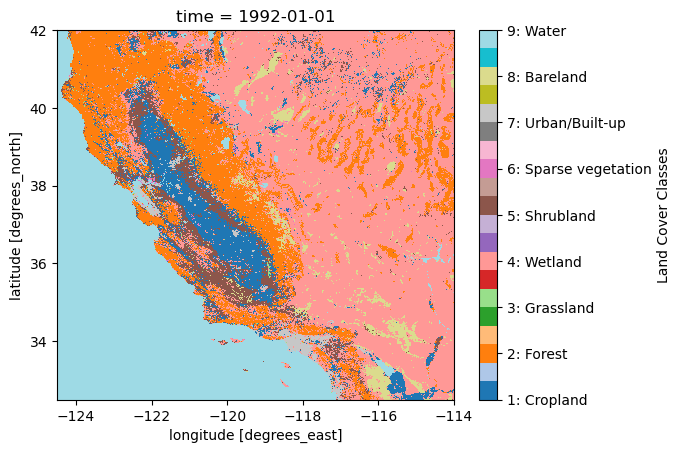

In [15]:
import xarray as xr
import glob
import os
import numpy as np

reclassed_ds = xr.open_dataset("output/ca_lccs.nc")

# Create a dictionary mapping class values to descriptions
class_descriptions = {
    1: 'Cropland',
    2: 'Forest', 
    3: 'Grassland',
    4: 'Wetland',
    5: 'Shrubland',
    6: 'Sparse vegetation',
    7: 'Urban/Built-up',
    8: 'Bareland',
    9: 'Water'
}

# Plot with custom colormap and legend
plot = ca_ds["lccs_class"].isel(time=0).plot(
    cmap='tab20',
    add_colorbar=True,
    cbar_kwargs={
        'label': 'Land Cover Classes',
        'ticks': list(class_descriptions.keys()),
        'format': lambda x, p: f'{int(x)}: {class_descriptions.get(int(x), "")}'
    }
)





### 农田

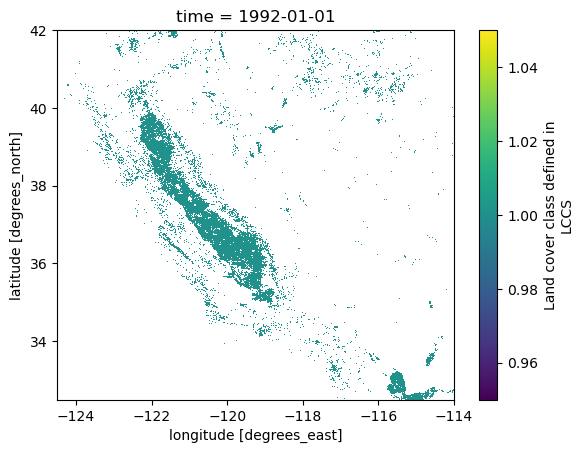

In [16]:
plot = ca_ds["lccs_class"].where(ca_ds["lccs_class"] == 1).isel(time=0).plot()

# 3. Identify the cropland abandonment



Given : xarray dataset rc，
It has following properties:
    Dimensions: time: 31 lat: 3420  lon: 3780
    data variable (int)：lccs_class
    Where cropland is 1.
    

Let 非人工区域(non_artificial)为（not cropland (1) nor 7 (built-up)）

Create a new dataset Output: rc_new it has "abandonment_year", abandonment_duration


1. 检测所有满足下列条件的像素生成mask:
   1. 所有年里存在农田(1)
   2. non_artificial 的数量应>=5
   3. 至少存在第一个点是1，第二个点是non_artificial的情况


2. 根据这个mask， 遍历所有满足条件的像素tqdm(series)

For each point in series:
    duration=0
    year=None
    if the point is cropland:
        if duration >=5 and (not year):
            save result.
            下一个点
        else:
            year=对应的年份
            duration=0
    if the point is non_artificial and (year not None):
        duration=duration+1
        
    if是最后一个点并且 duration >=5,
        save result.


Save the result of year into a variable  "abandonment_year"
Save the result of duration into variable  "abandonment_duration"





In [2]:
rc = xr.open_dataset("output/ca_lccs.nc")

In [27]:
rc

<xarray.Dataset> Size: 2GB
Dimensions:     (time: 31, lat: 3420, lon: 3780)
Coordinates:
  * lat         (lat) float64 27kB 42.0 42.0 41.99 41.99 ... 32.51 32.5 32.5
  * lon         (lon) float64 30kB -124.5 -124.5 -124.5 ... -114.0 -114.0 -114.0
  * time        (time) datetime64[ns] 248B 1992-01-01 1993-01-01 ... 2022-01-01
Data variables:
    lccs_class  (time, lat, lon) float32 2GB 9.0 9.0 9.0 9.0 ... 4.0 4.0 4.0 8.0
Attributes: (12/38)
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-1992-v2.0.7cds
    title:                      Land Cover Map of ESA CCI brokered by CDS
    summary:                    This dataset characterizes the land cover of ...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [ ]:
import numpy as np
import xarray as xr
from tqdm import tqdm
# Create mask where:
# 1. Cropland exists in any year
# 2. Non-artificial areas >= 5 years
# 3. At least one sequence starts with cropland followed by non-artificial
cropland_exists = (rc.lccs_class == 1).any(dim='time')
non_artificial = ((rc.lccs_class != 1) & (rc.lccs_class != 7)).sum(dim='time') >= 5

# Check for cropland followed by non-artificial
has_sequence = False
for t in range(len(rc.time)-1):
    cropland_t = rc.lccs_class.isel(time=t) == 1
    non_artificial_t1 = (rc.lccs_class.isel(time=t+1) != 1) & (rc.lccs_class.isel(time=t+1) != 7)
    has_sequence = has_sequence | (cropland_t & non_artificial_t1)

mask = cropland_exists & non_artificial & has_sequence


# Create output arrays initialized with NaN
abandonment_year = np.full(rc.lccs_class.shape[1:], np.nan)
abandonment_duration = np.full(rc.lccs_class.shape[1:], np.nan)

# Get indices of masked pixels
lat_idx, lon_idx = np.where(mask)

# Iterate through masked pixels
for i, j in tqdm(zip(lat_idx, lon_idx), total=len(lat_idx)):
    duration = 0
    year = None
    series = rc.lccs_class.isel(lat=i, lon=j)
    for t, val in enumerate(series):
        if val == 1 :  # Cropland 
            if duration >= 5 and year is None:  # Save previous abandonment if duration met and no abandonment started
                abandonment_year[i,j] = year
                abandonment_duration[i,j] = duration
                break
            else:
                year = rc.time[t].values
                duration = 0
        elif ((val != 1) and (val != 7)) and year is not None:  # Non-artificial after cropland
            duration += 1
        else:  # Reset if we see cropland again before 5 years
            year = None
            duration = 0
        # Check last point
        if t == len(series)-1 and duration >= 5:
            abandonment_year[i,j] = year
            abandonment_duration[i,j] = duration

# Create new dataset with results
rc_new = xr.Dataset(
    data_vars={
        'abandonment_year': (['lat', 'lon'], abandonment_year),
        'abandonment_duration': (['lat', 'lon'], abandonment_duration)
    },
    coords={
        'lat': rc.lat,
        'lon': rc.lon
    }
)


Number of non-NaN points: 30776


array([1., 1., 1., 1., 1., 1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
      dtype=float32)

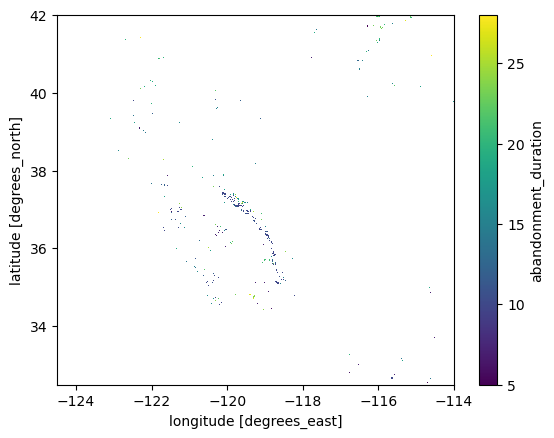

In [22]:
print(f"Number of non-NaN points: {np.count_nonzero(~np.isnan(rc_new['abandonment_duration']))}")
rc_new["abandonment_duration"].plot()


# Find first non-NaN point coordinates
valid_idx = np.where(~np.isnan(rc_new['abandonment_duration']))
example_i, example_j = valid_idx[0][0], valid_idx[1][0]

rc_new.isel(lat=example_i, lon=example_j)
rc["lccs_class"].isel(lat=example_i, lon=example_j).values


In [26]:
rc_new["abandonment_year"].isel(lat=example_i, lon=example_j)

<xarray.DataArray 'abandonment_year' ()> Size: 8B
array(8.836128e+17)
Coordinates:
    lat      float64 8B 42.0
    lon      float64 8B -116.1

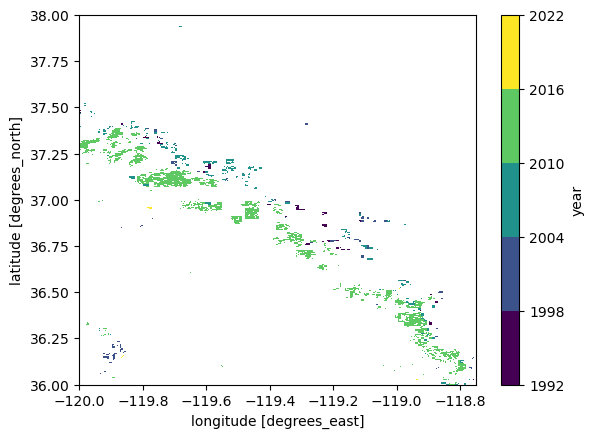

In [33]:
# Create 5 bins for years between 1992-2022
rc_new["abandonment_year"].astype('datetime64[ns]').dt.year.sel(lon=slice(-120,-118.75), lat=slice(38,36)).plot(
    cmap='viridis',
    levels=[1992, 1998, 2004, 2010, 2016, 2022]  # Split into 5 intervals
)



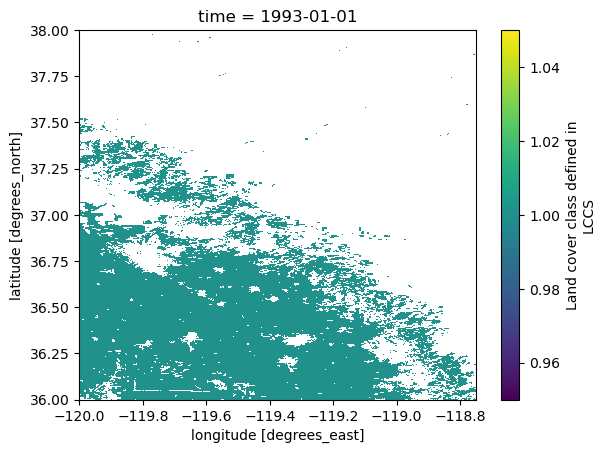

In [37]:
rc["lccs_class"].isel(time=1).sel(lon=slice(-120,-118.75), lat=slice(38,36)).where(rc["lccs_class"].isel(time=1) == 1).plot()

# 全球撂荒耕地对气候行动的潜在贡献被显著低估
# 应该慎重考虑耕地撂荒再开发以避免可持续发展目标or人类福祉受损

ceteris paribus(to control the other factors unvaried)

Agricultutal land abandonment: The FAO defines as agricultual land a portion of land dedicated to food production, and if this condition ceases for a period longer than 5 years, the land is considered abandoned.


## 1. cropland abandonment(1992-2022):
firstly, combine 31 datasets into one, this step is to make sure the data is time continuous. 

core aim: to identify the cropland abandonment, the abdonment could be defined as rules as:

caculation 1: expansion cropland but persistent abandonment  
caculation 2: stable cropland and persistent abandonment 
caculation 3: abandonment and recultivation (abandonment and built-up should alse be excluded)

before calculation, the data should be reclassified to 1992-2022, and the reclassification rules should follow the following rules[1](https://www.nature.com/articles/s41597-020-00599-8#:~:text=Independently%20validating%20a%20glob):

1. forest(50:50-90,160,170)
2. savanna(100,110)
3. cropland(10:10-40)
4. built-up(190)
5. wetland(180)
6. shrub(120:120-122)
7. arid ecosystem(150:140,150-153)
8. bare area and ice(200:200-202)
9. water(210)
10. grassland(130)

===========================================================
small calculation:
1) in calculation 1, to see the interval of expansion pixels and abandonment, the first time of expansion, the first time of abandonment; 
2) in calculation 3, to see the persistence of abandonment;
3) in calculation 2, to see the first time of cropland abandonment;

(each condition should be independent)

--->---calcluation 1: expansion cropland but persistent abandonment

aim: to see if the cropland expansion hotspot shift to Global South and to see if the hotspot transformation is due to the Global North cropland abandonment.

1) _**effective change**_:change to cropland and remain for at least 2 years;
2) _**persistence**_: after identified as abandonment, it remains non-cropland (excluding built-up area)
3) _**long-term non-cropland**_: GLC_FCS data using majority method to resample to 1km resolution. If the pixel in 1985 and 1990 are non-cropland, but it changed within the first 5 years (convert for 2 consecutive years like ), it could also be considered as cropland expansion. (to avoid underminishing the cropland expansion). According to [referencen], not consider 1985 and 1990 cropland.

--->---calculation 2: stable cropland and persistent abandonment 

aim: some reseach only consider the initial cropland, however, the immigration and scoical-economic fators may accelerate the cropland abandonment.


1) _**effecitive abandon**_:the consecutive 5 years of non-cropland (exclude built-up area);
2) _**persistence**_: it should remain as abandonment 
3) _**stable cropland**_:GLC_FCS to ensure the effectiveness of abandonment. If a conversion happens within the first 5 years, and 1985 and 1990 are cropland, it should be considered as cropland abandonment;

--->---calculation 3: abandonment and recultivation

aim: this situation is considered as special situation, to see with time-series data, 

1) _**effective abandon**_: it should be identified as cropland abandonment
2) _**reclutivate change**_: the pixel turns back to cropland for two consecutive years
3) _**persitence**_: the first time is just OK



## 2. reclassification and biodiversity:






## Nexus approach of analyzing complex interlinkages


